# Apple Disease Detection


SEBlock: https://medium.com/@tahasamavati/squeeze-and-excitation-explained-387b5981f249

DepthwiseConv2D layer: https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 

import warnings
warnings.filterwarnings('ignore')
import kagglehub

path = kagglehub.dataset_download("ludehsar/apple-disease-dataset")
print("Path to dataset files:", path)


TRAIN_PATH = os.path.join(path, 'datasets/train')
categories = os.listdir(os.path.join(path, 'datasets/train'))

image_paths  = []
labels = []

for element in categories:
    category_path = os.path.join(TRAIN_PATH, element)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(element)

data = pd.DataFrame({'image_path': image_paths, 'label': labels})
data = data.sample(n = data.shape[0]).reset_index(drop = True)   # Shuffle data
print(data.shape)
print(data.label.unique())
print(data.label.value_counts())
data.head()

Path to dataset files: /Users/nathandouieb/.cache/kagglehub/datasets/ludehsar/apple-disease-dataset/versions/1
(7771, 2)
['cedar_apple_rust' 'black_rot' 'apple_scab' 'healthy']
label
apple_scab          2016
healthy             2008
black_rot           1987
cedar_apple_rust    1760
Name: count, dtype: int64


,image_path,label
0,/Users/nathandouieb/.cache/kagglehub/datasets/...,cedar_apple_rust
1,/Users/nathandouieb/.cache/kagglehub/datasets/...,black_rot
2,/Users/nathandouieb/.cache/kagglehub/datasets/...,cedar_apple_rust
3,/Users/nathandouieb/.cache/kagglehub/datasets/...,cedar_apple_rust
4,/Users/nathandouieb/.cache/kagglehub/datasets/...,apple_scab


In [4]:
# Encodinf target
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
data['label'] = encode.fit_transform(data['label'])
print(f'Classes: {encode.classes_}')
data.head()

Classes: ['apple_scab' 'black_rot' 'cedar_apple_rust' 'healthy']


,image_path,label
0,/Users/nathandouieb/.cache/kagglehub/datasets/...,2
1,/Users/nathandouieb/.cache/kagglehub/datasets/...,1
2,/Users/nathandouieb/.cache/kagglehub/datasets/...,2
3,/Users/nathandouieb/.cache/kagglehub/datasets/...,2
4,/Users/nathandouieb/.cache/kagglehub/datasets/...,0


In [5]:
# Balanced data by class
# Dans chaque groupe, on prélève aléatoirement le même nombre d'échantillons que la classe la moins représentée
data_balanced = data.groupby('label').sample(n = data.label.value_counts().min()).reset_index(drop = True)
data_balanced['label'] = data_balanced['label'].astype(str)
print(data_balanced.label.dtype)
data_balanced.shape

object


(7040, 2)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

data_train, data_temp = train_test_split(data_balanced, test_size = 0.2, stratify = data_balanced.label, shuffle = True, random_state = 42)
data_valid, data_test = train_test_split(data_temp, test_size = 0.5, stratify = data_temp.label, shuffle = True, random_state = 42)
print(f'Data train: {data_train.shape}')
print(f'Data valid: {data_valid.shape}')
print(f'Data test: {data_test.shape}]')

Data train: (5632, 2)
Data valid: (704, 2)
Data test: (704, 2)]


In [7]:
# Proprocessing & Data Augmentation
tr_generator = ImageDataGenerator(rescale = 1./255)
ts_generator = ImageDataGenerator(rescale = 1./255)

train_generator = tr_generator.flow_from_dataframe(dataframe = data_train, 
                                    x_col = 'image_path', 
                                    y_col = 'label', 
                                    target_size = (224, 224), 
                                    class_mode = 'sparse',      # categorical -> one-hot   : sparse -> entier  
                                    color_mode = 'rgb', 
                                    shuffle = True, 
                                    batch_size = 16)

valid_generator = ts_generator.flow_from_dataframe(dataframe = data_valid, 
                                    x_col = 'image_path', 
                                    y_col = 'label', 
                                    target_size = (224, 224), 
                                    class_mode = 'sparse', 
                                    color_mode = 'rgb', 
                                    shuffle = True, 
                                    batch_size = 16)

test_generator = ts_generator.flow_from_dataframe(dataframe = data_test, 
                                    x_col = 'image_path', 
                                    y_col = 'label', 
                                    target_size = (224, 224), 
                                    class_mode = 'sparse', 
                                    color_mode = 'rgb', 
                                    shuffle = False,
                                    batch_size = 16)

Found 5632 validated image filenames belonging to 4 classes.
Found 704 validated image filenames belonging to 4 classes.
Found 704 validated image filenames belonging to 4 classes.


### Residual Connections
Dans un réseau de neurones profond, chaque couche est censée apprendre une transformation utile de l'information. Mais sans résidual connection, plus on ajoute de couches, plus le modèle peut avoir du mal à apprendre correctement : il peut dégrader l’information, oublier des détails importants, ou même apprendre moins bien qu’un réseau plus simple. 

La résidual connection vient résoudre ce problème en faisant passer directement l’entrée originale jusqu’à la fin du bloc, en l’ajoutant à la sortie transformée. Cela permet au modèle de choisir : soit il modifie légèrement l’entrée s’il a quelque chose d’utile à apprendre, soit il la garde telle quelle si elle est déjà bonne. En pratique, cela rend l’apprentissage plus stable, plus rapide, et beaucoup plus efficace, surtout dans des réseaux très profonds.


In [8]:
class SEBlock(layers.Layer):
    ''' 
    Le SEBlock est souvent utilisée dans les réseaux de neurones 
    pour renforcer les canaux importants (Squeeze-and-Excitation Block)

    Le SEBlock apprend à "peser" l’importance de chaque canal 
    et à les renforcer ou diminuer pour de meilleures performances.

    Fonctionnement: Au début le réseau traite tous les canaux de manière égale, 
    malgré si certains sont plus utiles que d'autres. 

    Ce que fait le SEBlock :
    1. GlobalAveragePooling2D : Il fait la moyenne de chaque canal, donc il résume chaque canal par un seul nombre.
    Par exemple si nous avons 3 canaux, nous obtiendrons un vecteur de 3 nombres, comme : [0.2, 1.5, 0.7]
    ce sont des sortes de "scores bruts" pour chaque canal. 
    2. Denses + sigmoid : Ces couches permettent au modèle d’apprendre une "pondération" entre 0 et 1 pour chaque canal
    Exemple après le sigmoid: [0.1, 0.9, 0.3] -> canal 2 très important
    3. Multiplication final : Nous multiplions chaque canal de l’image par son importance, 
    donc le réseau se concentre plus sur ce qui est utile.
    '''
    def __init__(self, ratio = 16): # reduction de la taille des canaux
        super(SEBlock, self).__init__()
        self.ratio = ratio
    
    def build(self, input_shape):
        self.channels = input_shape[-1]   # 3
        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(units = max(1, self.channels // self.ratio), activation = 'swish') # units = 5
        self.fc2 = layers.Dense(units = self.channels, activation = 'sigmoid')             # units = 3
        self.reshape = layers.Reshape((1, 1, self.channels))

    def call(self, inputs):
        se = self.global_pool(inputs)
        se = self.fc1(se)
        se = self.fc2(se)
        se = self.reshape(se)
        return inputs * se
    

class Avg2MaxPooling(layers.Layer):
    ''' 
    Extraire des motifs particuliers dans l’image en combinant moyenne et maximum,
    (cela peut rendre le réseau plus sensible à des détails subtils) 
    puis amplifier les contrastes entre zones calmes et zones fortes.
    Les deux opérations que nous appliquons ici sont:
    * AveragePooling2D: "quelles valeurs sont globalement présentes dans cette zone ?"
    * MaxPooling2D:  "quelle est la valeur dominante dans cette zone ?"
    '''
    def __init__(self, pool_size = 3, strides = 2, padding = 'same'):
        super(Avg2MaxPooling, self).__init__()
        self.avg_pool = layers.AveragePooling2D(pool_size = pool_size, strides = strides, padding = padding)
        self.max_pool = layers.MaxPooling2D(pool_size = pool_size, strides = strides, padding = padding)
        self.bn = layers.BatchNormalization()

    def call(self, inputs):
        ''' 
        mean - 2 * max:
        "Si une valeur ressort beaucoup trop par rapport à la moyenne,
        je vais l'écraser fortement."
        '''
        x = self.avg_pool(inputs) - 2 * self.max_pool(inputs)
        return self.bn(x)



class DepthwiseSeparableConv(layers.Layer):
    ''' 
    Traiter chaque canal séparément puis les mélanger intelligemment. Cela crée des réseaux efficaces et puissants
    
    Depthwise Convolution: Appliquer une convolution séparée sur chaque canal individuellement (R, G, B)
    Il n'y a pas ici de mélange entre les canaux.
    Conv2D: Ensuite nous appliquons une convolution 1x1 pour mélanger les canaux entre eux. C'est la que 
    nous créeons des interactions complexes. 
    SEBlock: Appliquer le module d’attention sur les canaux,

    '''
    def __init__(self, filters, kernel_size = 3, strides = 1, se_ratio = 16):
        super(DepthwiseSeparableConv, self).__init__()
        self.dw = layers.DepthwiseConv2D(kernel_size = kernel_size, strides = strides, padding = 'same')
        self.pw = layers.Conv2D(filters = filters, kernel_size = 1, strides = 1)
        self.bn = layers.BatchNormalization()
        self.se = SEBlock(se_ratio)
        # Si stride = 1, la taille ne change pas, sinon x.shape ≠ inputs.shape donc (x + residual) va planter.  
        # Il faut donc projeter inputs dans la même taille que x
        self.proj = layers.Conv2D(filters = filters, kernel_size = 1, strides = 1) if strides != 1 else None

    def call(self, inputs):
        residual  = inputs
        x = self.dw(inputs)
        x = self.pw(x)
        x = self.bn(x)
        x = tf.nn.swish(x)
        x = self.se(x)
        if self.proj is not None:
            residual = self.proj(residual)
        return x + residual if residual.shape == x.shape else x
    


def create_geometric_net(input_shape = (224, 224, 3), num_classes = 4):
    inputs = layers.Input(shape = input_shape)

    x = layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = layers.Conv2D(filters = 48, kernel_size = (3, 3), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x2 = layers.Activation('swish')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)

    x = layers.Conv2D(filters = 72, kernel_size = (3, 3), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x3 = layers.Activation('swish')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)

    pcb1 = layers.Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same')(x2)
    pcb1 = Avg2MaxPooling()(pcb1)
    pcb1 = layers.Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same')(pcb1)
    pcb1 = Avg2MaxPooling()(pcb1)

    x = layers.Conv2D(filters = 108, kernel_size = (3, 3), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)

    pcb1 = layers.Resizing(14, 14)(pcb1)
    x = layers.concatenate([x , pcb1])
    x = layers.Conv2D(filters = 108, kernel_size = (1, 1), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    pcb2 = layers.Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same')(x3)
    pcb2 = Avg2MaxPooling()(pcb2)
    pcb2 = layers.Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same')(pcb2)
    pcb2 = Avg2MaxPooling()(pcb2)

    x = layers.Conv2D(filters = 162, kernel_size = (3, 3), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)

    pcb2 = layers.Resizing(7, 7)(pcb2)
    x = layers.concatenate([x , pcb2])
    x = layers.Conv2D(filters = 162, kernel_size = (1, 1), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = DepthwiseSeparableConv(243)(x)
    x = DepthwiseSeparableConv(365)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units = num_classes, activation = 'softmax', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)

    return tf.keras.models.Model(inputs, outputs)


model = create_geometric_net(num_classes = 4)
model.summary()

2025-05-01 21:48:14.013550: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-01 21:48:14.013757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-01 21:48:14.013768: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-01 21:48:14.014250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-01 21:48:14.014275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     13,872 │ activation_1[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     31,176 │ max_pooling2d[0]… │
│                     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        288 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     10,392 │ activation_2[0][… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     70,092 │ max_pooling2d_1[… │
│                     │ 108)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg2_max_pooling    │ (None, 56, 56,    │         96 │ conv2d_4[0][0]  

 Total params: 527,842 (2.01 MB)

 Trainable params: 524,986 (2.00 MB)

 Non-trainable params: 2,856 (11.16 KB)

In [9]:
model.compile(optimizer = Adam(), 
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])

history = model.fit(train_generator, 
                    validation_data = valid_generator, 
                    epochs = 5, 
                    batch_size = 16)

Epoch 1/5


2025-05-01 21:48:20.982852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


352/352 ━━━━━━━━━━━━━━━━━━━━ 128s 334ms/step - accuracy: 0.7967 - loss: 0.5338 - val_accuracy: 0.4489 - val_loss: 1.4028
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 106s 301ms/step - accuracy: 0.9487 - loss: 0.1507 - val_accuracy: 0.8679 - val_loss: 0.5658
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 105s 296ms/step - accuracy: 0.9678 - loss: 0.1036 - val_accuracy: 0.9489 - val_loss: 0.1529
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.9674 - loss: 0.1051 - val_accuracy: 0.9787 - val_loss: 0.0798
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 110s 312ms/step - accuracy: 0.9842 - loss: 0.0589 - val_accuracy: 0.9957 - val_loss: 0.0292


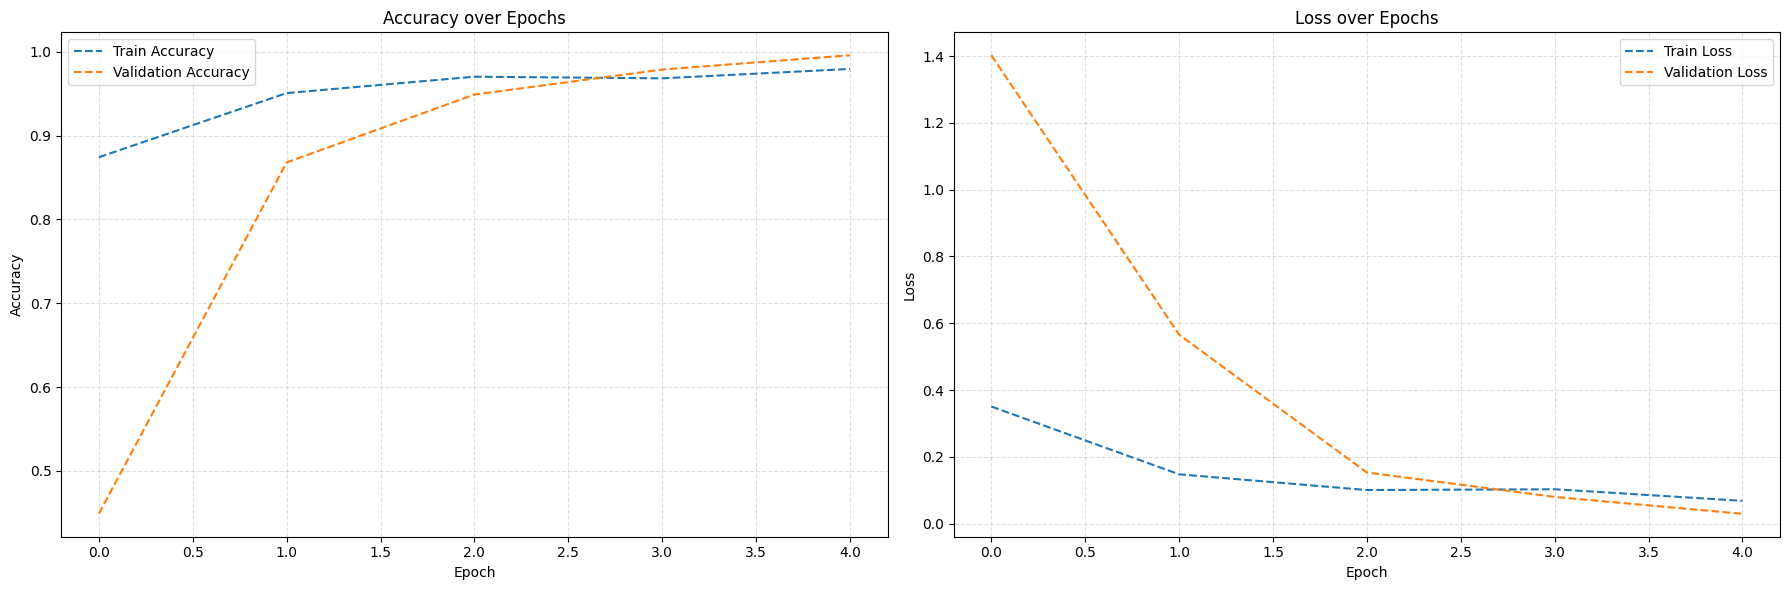

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_history(history):
    plt.figure(figsize = (18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'Train Accuracy', ls = '--')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', ls = '--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, ls = '--', alpha = 0.4)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'Train Loss', ls = '--')
    plt.plot(history.history['val_loss'], label = 'Validation Loss', ls = '--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, ls = '--', alpha = 0.4)
    plt.show()

plot_history(history)

In [33]:
from sklearn.metrics import confusion_matrix

# Evaluation on Test Data
predictions = model.predict(test_generator)
predicted_class = np.argmax(predictions, axis = 1)
true_classes = test_generator.labels

conf_matrix = confusion_matrix(true_classes, predicted_class)
print(conf_matrix)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
[[175   0   0   1]
 [  1 175   0   0]
 [  3   2 169   2]
 [  2   0   0 174]]


In [34]:
print(classification_report(y_true = true_classes, y_pred = predicted_class, target_names = encode.classes_))

                  precision    recall  f1-score   support

      apple_scab       0.97      0.99      0.98       176
       black_rot       0.99      0.99      0.99       176
cedar_apple_rust       1.00      0.96      0.98       176
         healthy       0.98      0.99      0.99       176

        accuracy                           0.98       704
       macro avg       0.98      0.98      0.98       704
    weighted avg       0.98      0.98      0.98       704



# Testing with new Data

In [ ]:
image_test = cv2.imread('Test_images/test1.jpg')
image_test = image_test / 255

array([[[0.24313725, 0.69019608, 0.75686275],
        [0.24313725, 0.69019608, 0.75686275],
        [0.24705882, 0.69411765, 0.76078431],
        ...,
        [0.57647059, 1.        , 1.        ],
        [0.47058824, 0.94117647, 0.96078431],
        [0.49019608, 0.97254902, 0.98823529]],

       [[0.23921569, 0.68627451, 0.75294118],
        [0.24313725, 0.69019608, 0.75686275],
        [0.24705882, 0.69411765, 0.76078431],
        ...,
        [0.4       , 0.84705882, 0.87058824],
        [0.51372549, 0.97647059, 0.99607843],
        [0.56470588, 1.        , 1.        ]],

       [[0.23921569, 0.68627451, 0.75294118],
        [0.23921569, 0.68627451, 0.75294118],
        [0.24313725, 0.69019608, 0.75686275],
        ...,
        [0.17254902, 0.59215686, 0.61960784],
        [0.30980392, 0.74901961, 0.77254902],
        [0.34509804, 0.79215686, 0.81568627]],

       ...,

       [[0.23921569, 0.48235294, 0.55294118],
        [0.23921569, 0.48235294, 0.55294118],
        [0.23921569, 0